In [6]:
import numpy as np
import h5py
import pylab as plt
from astropy.table import Table
from cal_caustic_area import cal_caustic_area,cal_caustic_arcsec, cal_ein_radius
import foreground_model as fg
import astropy.units as u

In [10]:
fg.cosmo_astropy.comoving_volume(0.5)

<Quantity 3.0863773e+10 Mpc3>

In [2]:
import background_source as bg
a = bg.ELCOSMOS()

In [8]:
a.fiducial_mean_N*(1.38*u.deg**2).to('sr')

<Quantity 663832.11 sr>

In [4]:
b = bg.OII_emitter()
b.set_interp()
b.set_fiducial_mean_N()
b.fiducial_mean_N

1579195446.918278

In [5]:
b.fiducial_mean_N/a.fiducial_mean_N

2.9100767157922602

In [30]:
with h5py.File('../data/fg_with_bg_source.h5', 'r') as fg_with_bg:
    print(fg_with_bg.keys())
    alpha_sps = fg_with_bg['alpha_sps'][()]
    gamma_DM = fg_with_bg['gamma_DM'][()]
    logMh = fg_with_bg['logMh'][()]
    logMstar = fg_with_bg['logMstar'][()]
    logRe = fg_with_bg['logRe'][()]
    logc = fg_with_bg['logc'][()]
    num_bg = fg_with_bg['num_bg'][()]
    q = fg_with_bg['q'][()]
    r_ein = fg_with_bg['r_ein'][()]
    radcaustic_sr = fg_with_bg['radcaustic_sr'][()]
    rhos = fg_with_bg['rhos'][()]
    rs = fg_with_bg['rs'][()]
    z_foreground = fg_with_bg['z_foreground'][()]
    fg_with_bg_table = Table([alpha_sps, gamma_DM, logMh, logMstar, logRe, logc, num_bg, q, r_ein, radcaustic_sr, rhos, rs, z_foreground], names=('alpha_sps', 'gamma_DM', 'logMh', 'logMstar', 'logRe', 'logc', 'num_bg', 'q', 'r_ein', 'radcaustic_sr', 'rhos', 'rs', 'z_foreground'))

<KeysViewHDF5 ['alpha_sps', 'gamma_DM', 'logMh', 'logMstar', 'logRe', 'logc', 'num_bg', 'q', 'r_ein', 'radcaustic_sr', 'rhos', 'rs', 'z_foreground']>


## test caustic area
see if it is consistent with that calculated from glafic

In [3]:
ind = 619
rhos = rhos[ind]
rs = rs[ind]
gamma_DM = gamma_DM[ind]
logMstar = logMstar[ind]
logRe = logRe[ind]
z_foreground = z_foreground[ind]
logMh = logMh[ind]
c = 10**logc[ind]
r_ein = r_ein[ind]
caustic_sr = radcaustic_sr[ind]

In [4]:
r_ein

0.7271050757319232

In [21]:
import glafic 
from astropy.cosmology import FlatLambdaCDM
import foreground_model as fg
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
# out = '/root/4MOST_lensing_prediction/data/glafic_output/test_caustic'
p = [fg.cosmo_astropy.Om0, fg.cosmo_astropy.Ode0, fg.cosmo_astropy.w(0), fg.cosmo_astropy.h, 'test_caustic', -5, -5, 5, 5, 0.1, 0.1, 5]
#[omega, lambda, weos, hubble, prefix, xmin[arcsec], ymin[arcsec], xmax[arcsec], ymax[arcsec], pix_ext[arcsec], pix_poi[arcsec], maxlev]
glafic.init(*p)
glafic.startup_setnum(2,0,0)
q = 1
e = 1 - q
glafic.set_lens(1,'gnfw', z_foreground,10**logMh*0.7,0,0,e,90,c/(2-gamma_DM), gamma_DM)
glafic.set_lens(2,'sers',z_foreground,10**logMstar*0.7,0,0,e,90,10**logRe*cosmo.arcsec_per_kpc_proper(z_foreground).value, 4)
glafic.model_init()

Rein_arcsec = glafic.calcein2(2.5,0,0,0)
print(Rein_arcsec)
glafic.writecrit(2.5)

0.7261335022778452


######## parameter definition
omega    =  3.071000e-01
lambda   =  6.928089e-01
weos     =  -1.000000e+00
hubble   =  6.777000e-01
prefix   =  test_caustic
xmin     =  -5.000000e+00
ymin     =  -5.000000e+00
xmax     =  5.000000e+00
ymax     =  5.000000e+00
pix_ext  =  1.000000e-01
nx_ext   =  100
ny_ext   =  100
pix_poi  =  1.000000e-01
nx_poi   =  100
ny_poi   =  100
maxlev   =  5
ran_seed =  -1234

lens   gnfw    0.0466  1.382304e+12  0.000000e+00  0.000000e+00  0.000000e+00  9.000000e+01  9.783713e+00  1.253386e+00 
lens   sers    0.0466  1.055892e+11  0.000000e+00  0.000000e+00  0.000000e+00  9.000000e+01  7.190431e+00  4.000000e+00 

0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 

lens plane  1 : z = 0.046584

   initializing the adaptive mesh...
   N_box ( lev =  1  pix_size =  0.10000 ) = 9801
   N_box ( lev =  2  pix_size =  0.05000 ) = 308
   N_box ( lev =  3  pix_size =  0.02500 ) = 628
   N_box ( lev =  4  pix_size =  0.01250 ) = 1440
   N_box ( lev =  5  pix_size =  0.00625 ) = 3168

#

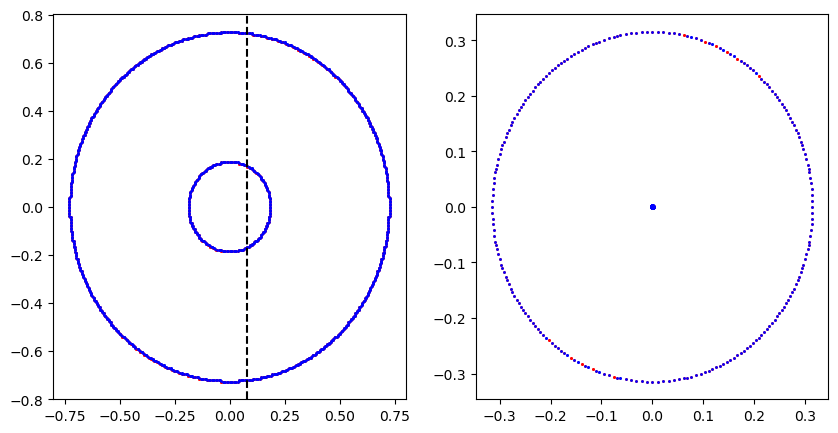

In [22]:
read_caustic = np.genfromtxt('./test_caustic_crit.dat')
xi1 = read_caustic[:,0]
yi1 = read_caustic[:,1]
xs1 = read_caustic[:,2]
ys1 = read_caustic[:,3]
xi2 = read_caustic[:,4]
yi2 = read_caustic[:,5]
xs2 = read_caustic[:,6]
ys2 = read_caustic[:,7]

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(xi1, yi1, s=1, c='r')
ax[0].scatter(xi2, yi2, s=1, c='b')
ax[0].axvline(0.08, c='k', ls='--')

ax[1].scatter(xs1, ys1, s=1, c='r')
ax[1].scatter(xs2, ys2, s=1, c='b')

plt.show()

# glafic.calcein_i(0.7)

In [26]:
import astropy.units as u
caustic_sr = caustic_sr*u.sr
caustic_arcsec = caustic_sr.to(u.arcsec**2)
print(np.sqrt(caustic_arcsec))

0.31936886286450683 arcsec


In [28]:
np.sqrt(caustic_arcsec)/np.sqrt(q)

<Quantity 0.31936886 arcsec>

## correct for rein

In [4]:
with h5py.File('../data/foreground_sample_backup.h5', 'r+') as sample:
    alpha_sps = sample['alpha_sps'][()]
    gamma_DM = sample['gamma_DM'][()]
    logMh = sample['logMh'][()]
    logMstar = sample['logMstar'][()]
    logRe = sample['logRe'][()]
    logc = sample['c'][()]
    q = sample['q'][()]
    r_ein = sample['r_ein_arcsec'][()]
    radcaustic_sr = sample['radcaustic_sr'][()]
    rhos = sample['rhos'][()]
    rs = sample['rs'][()]
    z_foreground = sample['z'][()]
    del sample['r_ein_arcsec']
    sample.create_dataset('r_ein_arcsec',data = r_ein_right)
    del sample['radcaustic_sr']
    sample.create_dataset('radcaustic_sr', data=radcaustic_sr_right)
    sample.create_dataset('logMstar_true', data=logMstar_true)

In [11]:
ind = 55241
rhos_i = rhos[ind]
rs_i = rs[ind]
gamma_DM_i = gamma_DM[ind]
logMstar_i = logMstar[ind]
logRe_i = logRe[ind]
z_foreground_i = z_foreground[ind]
logMh_i = logMh[ind]
c_i = 10**logc[ind]
r_ein_i = r_ein[ind]
caustic_sr_i = radcaustic_sr[ind]

In [25]:
# del cal_caustic_area
from cal_caustic_area import cal_caustic_area,cal_caustic_arcsec, cal_ein_radius,mu_r

In [13]:
r_ein_right = np.zeros(len(r_ein))
logMstar_true = np.zeros(len(r_ein))
radcaustic_sr_right = np.zeros(len(r_ein))
rs_arcsec = rs * fg.cosmo_astropy.arcsec_per_kpc_proper(z_foreground).value
for i in range(len(r_ein)):
    print('correcting r_ein for ', i, 'th source')
    logMstar_true[i] = logMstar[i]+np.log10(alpha_sps[i])
    r_ein_right[i] = cal_ein_radius(rhos[i], rs[i], gamma_DM[i], 10**logMstar_true[i], 10**logRe[i], z_foreground[i], 2.5)
    radcaustic_sr_right[i] = cal_caustic_area(rhos[i], rs[i], gamma_DM[i], 10**logMstar_true[i], 10**logRe[i], z_foreground[i], 2.5)

correcting r_ein for  0 th source
correcting r_ein for  1 th source
correcting r_ein for  2 th source


/tmp/ipykernel_55242/4175531216.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r_ein_right[i] = cal_ein_radius(rhos[i], rs[i], gamma_DM[i], 10**logMstar_true[i], 10**logRe[i], z_foreground[i], 2.5)
/tmp/ipykernel_55242/4175531216.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  radcaustic_sr_right[i] = cal_caustic_area(rhos[i], rs[i], gamma_DM[i], 10**logMstar_true[i], 10**logRe[i], z_foreground[i], 2.5)


correcting r_ein for  3 th source
correcting r_ein for  4 th source
correcting r_ein for  5 th source
correcting r_ein for  6 th source
correcting r_ein for  7 th source
correcting r_ein for  8 th source


/root/4MOST_lensing_prediction/codes/cal_caustic_area.py:25: RuntimeWarning: divide by zero encountered in reciprocal
  return (1+alpha(x, rhos,rs,gamma_DM, mstar,re,z_lens, z_source)/x - 2*kappa(x, rhos,rs,gamma_DM, mstar,re,z_lens, z_source))**(-1)


correcting r_ein for  9 th source
correcting r_ein for  10 th source
correcting r_ein for  11 th source
correcting r_ein for  12 th source
correcting r_ein for  13 th source
correcting r_ein for  14 th source
correcting r_ein for  15 th source
correcting r_ein for  16 th source
correcting r_ein for  17 th source
correcting r_ein for  18 th source
correcting r_ein for  19 th source
correcting r_ein for  20 th source
correcting r_ein for  21 th source
correcting r_ein for  22 th source
correcting r_ein for  23 th source
correcting r_ein for  24 th source
correcting r_ein for  25 th source
correcting r_ein for  26 th source
correcting r_ein for  27 th source
correcting r_ein for  28 th source
correcting r_ein for  29 th source
correcting r_ein for  30 th source
correcting r_ein for  31 th source
correcting r_ein for  32 th source
correcting r_ein for  33 th source
correcting r_ein for  34 th source
correcting r_ein for  35 th source
correcting r_ein for  36 th source
correcting r_ein for 

/root/4MOST_lensing_prediction/codes/profiles.py:86: RuntimeWarning: invalid value encountered in power
  M2d_here = self.M_interp.eval(sample)*(r/rs)**(3-gamma_DM)
/root/4MOST_lensing_prediction/codes/profiles.py:132: RuntimeWarning: invalid value encountered in scalar power
  out[i] = gammainc(2*self.n, self.bn*(r[i]/Re)**(1/self.n))


correcting r_ein for  1326 th source
correcting r_ein for  1327 th source
correcting r_ein for  1328 th source
correcting r_ein for  1329 th source
correcting r_ein for  1330 th source
correcting r_ein for  1331 th source
correcting r_ein for  1332 th source
correcting r_ein for  1333 th source
correcting r_ein for  1334 th source
correcting r_ein for  1335 th source
correcting r_ein for  1336 th source
correcting r_ein for  1337 th source
correcting r_ein for  1338 th source
correcting r_ein for  1339 th source
correcting r_ein for  1340 th source
correcting r_ein for  1341 th source
correcting r_ein for  1342 th source
correcting r_ein for  1343 th source
correcting r_ein for  1344 th source
correcting r_ein for  1345 th source
correcting r_ein for  1346 th source
correcting r_ein for  1347 th source
correcting r_ein for  1348 th source
correcting r_ein for  1349 th source
correcting r_ein for  1350 th source
correcting r_ein for  1351 th source
correcting r_ein for  1352 th source
c

/root/4MOST_lensing_prediction/codes/profiles.py:124: RuntimeWarning: invalid value encountered in scalar power
  out[i] = I0*np.exp(-self.bn*(r_array[i]/Re)**(1/self.n))


correcting r_ein for  38444 th source
correcting r_ein for  38445 th source
correcting r_ein for  38446 th source
correcting r_ein for  38447 th source
correcting r_ein for  38448 th source
correcting r_ein for  38449 th source
correcting r_ein for  38450 th source
correcting r_ein for  38451 th source
correcting r_ein for  38452 th source
correcting r_ein for  38453 th source
correcting r_ein for  38454 th source
correcting r_ein for  38455 th source
correcting r_ein for  38456 th source
correcting r_ein for  38457 th source
correcting r_ein for  38458 th source
correcting r_ein for  38459 th source
correcting r_ein for  38460 th source
correcting r_ein for  38461 th source
correcting r_ein for  38462 th source
correcting r_ein for  38463 th source
correcting r_ein for  38464 th source
correcting r_ein for  38465 th source
correcting r_ein for  38466 th source
correcting r_ein for  38467 th source
correcting r_ein for  38468 th source
correcting r_ein for  38469 th source
correcting r

## test run glafic to get image

In [29]:
with h5py.File('../data/fg_with_bg_source_group.h5', 'r') as galaxies:
    for i in range(len(galaxies)):
        id = str(i)
        sample = galaxies[id]
        alpha_sps = sample.attrs['alpha_sps']
        num_bg = sample.attrs['num_bg']
        z = sample['z_background'][()]
        x = sample['x_background'][()]
        y = sample['y_background'][()]
        print(x,y)

[-0.2259527] [0.21049238]
[-0.12803968] [0.14718226]
[0.47739075] [0.40502319]
[-0.73398565] [-0.01562185]
[-0.23028304] [-0.1192601]
[-0.04231652] [0.2118452]
[-0.01626974] [-0.48505918]
[-0.62669573] [-0.80582049]
[0.29015676] [-0.06247392]
[-0.31826731] [0.06778149]
[-0.29254399] [0.33075636]
[0.0694511] [-0.49149379]
[0.40597249] [-0.45304695]
[0.15638156] [-0.03858208]
[-0.46623405] [-0.50820109]
[0.48205875] [0.14513275]
[-0.08092299] [-0.12481628]
[-0.00091405] [0.02511615]
[0.03206474] [-0.03678304]
[-0.24339548] [0.03698705]
[-0.14899371] [-0.19551514]
[0.15302025] [0.10035814]
[-0.31046957] [0.41792425]
[0.18910482] [0.05207008]
[-0.52543221] [-1.31081005]
[0.59570689] [-0.14443344]
[-0.11550956] [0.03045171]
[-0.06283422] [-0.18334425]
[-0.4703126] [-0.18052]
[0.60807896] [-1.08204465]
[0.44513212] [0.03728583]
[0.03360076] [-0.14344585]
[-0.17881563] [0.78278448]
[-0.15617641] [1.20435275]
[0.21691438] [-0.2406308]
[0.10711012] [0.01261242]
[0.0591702] [0.55754117]
[1.08596

In [5]:
import glafic 
from astropy.cosmology import FlatLambdaCDM
import foreground_model as fg
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
# out = '/root/4MOST_lensing_prediction/data/glafic_output/test_caustic'
p = [fg.cosmo_astropy.Om0, fg.cosmo_astropy.Ode0, fg.cosmo_astropy.w(0), fg.cosmo_astropy.h, '/root/4MOST_lensing_prediction/data/test', -5, -5, 5, 5, 0.1, 0.1, 5]
#[omega, lambda, weos, hubble, prefix, xmin[arcsec], ymin[arcsec], xmax[arcsec], ymax[arcsec], pix_ext[arcsec], pix_poi[arcsec], maxlev]
glafic.init(*p)

with h5py.File('../data/potential_lense.h5', 'r') as galaxies:
    # for i in range(len(galaxies)):
        # id = str(i)
        id = '754'
        sample = galaxies[id]
        alpha_sps = sample.attrs['alpha_sps']
        gamma_DM = sample.attrs['gamma_DM']
        logMh = sample.attrs['logMh']
        logMstar = sample.attrs['logMstar']
        logRe = sample.attrs['logRe']
        logc = sample.attrs['logc']
        num_bg = sample.attrs['num_bg']
        q = sample.attrs['q']
        r_ein = sample.attrs['r_ein']
        radcaustic_arcsec = sample.attrs['radcaustic_arcsec']
        r_circ = sample.attrs['r_circle']
        print('r_cau= ',radcaustic_arcsec)
        print('r_circ = ', r_circ)
        rhos = sample.attrs['rhos']
        rs = sample.attrs['rs']
        z_foreground = sample.attrs['z_foreground']
        rs = rs * fg.cosmo_astropy.arcsec_per_kpc_proper(z_foreground).value

        c = 10**logc


        #* three number in startup_setnum are the number of lenses, extended sources, and point sources
        #* here we only consider point sources
        glafic.startup_setnum(2,0,num_bg)
        e = 1-q
        # if gamma_DM >=2:
            

        glafic.set_lens(1,'gnfw', z_foreground,10**logMh*0.7,0,0,e,90,rs, gamma_DM-0.3)
        glafic.set_secondary('nfw_users 1',verb = 0)
        # glafic.set_lens(1,'gnfw', z_foreground,10**logMh*0.7,0,0,e,90,c/(2-gamma_DM), gamma_DM)
        # glafic.set_secondary('nfw_users 0',verb = 0)
        glafic.set_lens(2,'sers',z_foreground,10**logMstar*0.7,0,0,e,90,10**logRe*cosmo.arcsec_per_kpc_proper(z_foreground).value, 4)
        
        for j in range(num_bg):
            z = sample['z_background'][j]
            x = sample['x_background'][j]
            y = sample['y_background'][j]
            glafic.set_point(j+1, z, x+0.07, y+1)
        
        glafic.model_init()
        galaxies.close()

        


r_cau=  5.523889315644498
r_circ =  7.596711062266299


######## parameter definition
omega    =  3.071000e-01
lambda   =  6.928089e-01
weos     =  -1.000000e+00
hubble   =  6.777000e-01
prefix   =  /root/4MOST_lensing_prediction/data/test
xmin     =  -5.000000e+00
ymin     =  -5.000000e+00
xmax     =  5.000000e+00
ymax     =  5.000000e+00
pix_ext  =  1.000000e-01
nx_ext   =  100
ny_ext   =  100
pix_poi  =  1.000000e-01
nx_poi   =  100
ny_poi   =  100
maxlev   =  5
ran_seed =  -1234

lens   gnfw    0.1287  9.717160e+12  0.000000e+00  0.000000e+00  2.386204e-01  9.000000e+01  4.274461e+01  1.735604e+00 
lens   sers    0.1287  2.234198e+11  0.000000e+00  0.000000e+00  2.386204e-01  9.000000e+01  3.978145e+00  4.000000e+00 
point  1.4824  1.235625e-01 -4.171079e+00 

0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 
0 0 0 

lens plane  1 : z = 0.128656



In [12]:
rs

42.74461172879016

In [3]:
glafic.findimg()
glafic.writecrit(1.41)

n_img = 0


######## finding images for point 1
 zs = 1.482370e+00  xs = 1.235625e-01  ys = -4.171079e+00
 output file name = /root/4MOST_lensing_prediction/data/test_point.dat 

 making tables for gnfw... [101 x 801 = 80901 points]

   initializing the adaptive mesh...
   N_box ( lev =  1  pix_size =  0.10000 ) = 9801
   N_box ( lev =  2  pix_size =  0.05000 ) = 1156
   N_box ( lev =  3  pix_size =  0.02500 ) = 2576
   N_box ( lev =  4  pix_size =  0.01250 ) = 6032
   N_box ( lev =  5  pix_size =  0.00625 ) = 15776


   initializing the adaptive mesh...
   N_box ( lev =  1  pix_size =  0.10000 ) = 9801
   N_box ( lev =  2  pix_size =  0.05000 ) = 1148
   N_box ( lev =  3  pix_size =  0.02500 ) = 2528
   N_box ( lev =  4  pix_size =  0.01250 ) = 5904
   N_box ( lev =  5  pix_size =  0.00625 ) = 15728

######## writing critical curve
 zs = 1.410000e+00 
 output file name = /root/4MOST_lensing_prediction/data/test_crit.dat 



In [ ]:
glafic.findimg()
glafic.writecrit(1.41)
        

n_img = 1


######## finding images for point 1
 zs = 9.909337e-01  xs = -5.770320e-01  ys = -3.696841e-01
 output file name = /root/4MOST_lensing_prediction/data/test_point.dat 

   initializing the adaptive mesh...
   N_box ( lev =  1  pix_size =  0.10000 ) = 9801
   N_box ( lev =  2  pix_size =  0.05000 ) = 676
   N_box ( lev =  3  pix_size =  0.02500 ) = 1440
   N_box ( lev =  4  pix_size =  0.01250 ) = 3104
   N_box ( lev =  5  pix_size =  0.00625 ) = 7616


   initializing the adaptive mesh...
   N_box ( lev =  1  pix_size =  0.10000 ) = 9801
   N_box ( lev =  2  pix_size =  0.05000 ) = 756
   N_box ( lev =  3  pix_size =  0.02500 ) = 1632
   N_box ( lev =  4  pix_size =  0.01250 ) = 3584
   N_box ( lev =  5  pix_size =  0.00625 ) = 8816

######## writing critical curve
 zs = 1.410000e+00 
 output file name = /root/4MOST_lensing_prediction/data/test_crit.dat 



x =   -0.9977   y =   -2.3686   mag =    3.1563 [  -1.248]   td[day] =     0.000


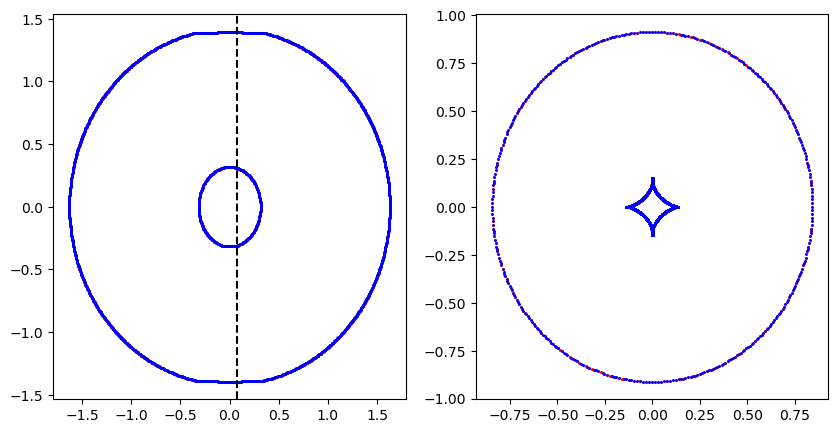

In [14]:
read_caustic = np.genfromtxt('../data/test_crit.dat')
xi1 = read_caustic[:,0]
yi1 = read_caustic[:,1]
xs1 = read_caustic[:,2]
ys1 = read_caustic[:,3]
xi2 = read_caustic[:,4]
yi2 = read_caustic[:,5]
xs2 = read_caustic[:,6]
ys2 = read_caustic[:,7]

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(xi1, yi1, s=1, c='r')
ax[0].scatter(xi2, yi2, s=1, c='b')
ax[0].axvline(0.08, c='k', ls='--')

ax[1].scatter(xs1, ys1, s=1, c='r')
ax[1].scatter(xs2, ys2, s=1, c='b')

plt.show()

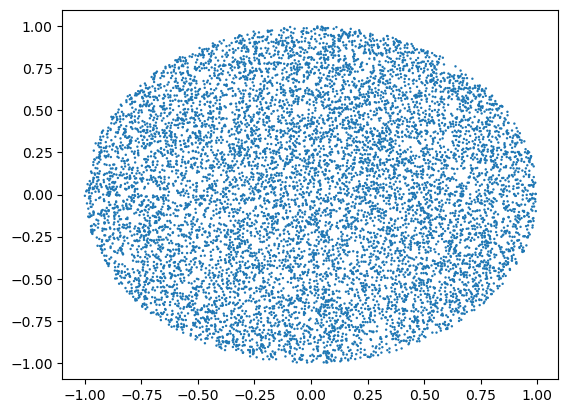

In [9]:
theta = np.random.rand(10000)*2*np.pi
r = np.sqrt(np.random.rand(10000))
# r = np.random.rand(10000)
x = np.cos(theta)*r
y = np.sin(theta)*r
plt.scatter(x, y, s = 3,edgecolors='none')